### Setup

In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

import matplotlib.pyplot as plt
import pickle 
import torch as th
import torch.nn.functional as F
import torch
import networkx as nx
import pandas as pd
import numpy as np
import dgl 

import torch_geometric
from torch_geometric.explain import Explainer, CaptumExplainer, DummyExplainer, GNNExplainer
from torch_geometric.explain.metric import *
from torch_geometric.nn.models.basic_gnn import GraphSAGE
from torch_geometric.utils import from_dgl
from tqdm import tqdm
from torch_geometric.explain import ModelConfig
import scienceplots
from explanations import *
        

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [2]:
test = pd.read_csv('../../interm/BoT_test.csv')
attrs = [c for c in test.columns if c not in ("src", "dst", "Attack", "x", "IPV4_SRC_ADDR_metadata", 
                                              "L4_SRC_PORT_metadata", 
                                              "IPV4_DST_ADDR_metadata", "L4_DST_PORT_metadata") 
        #  and not c.endswith('_metadata')
         ]
test['x'] = test[attrs].values.tolist()
test[:1]


,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,Attack,src,dst,x,FLOW_START_MILLISECONDS_metadata,FLOW_END_MILLISECONDS_metadata,IPV4_SRC_ADDR_metadata,L4_SRC_PORT_metadata,IPV4_DST_ADDR_metadata,L4_DST_PORT_metadata
0,-0.236904,-0.236926,-0.503789,106,-0.17034,-0.2804,-0.071477,-0.149842,1.257089,1.728738,...,0,192.168.100.3:-1.0586554,192.168.100.149:2.6106632,"[-0.23690394, -0.23692596, -0.5037887, 106.0, ...",1.526968e+12,1.526968e+12,192.168.100.3,80.0,192.168.100.149,34502.0


<IPython.core.display.Javascript object>

In [ ]:
def to_graph(data, linegraph=True):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph()) 
    
    G = G.to_directed()
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    if linegraph:
        return g.line_graph(shared=True)
    else:
        return g



/tmp/ipykernel_2759/3588832698.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))


GraphSAGE(49, 5, num_layers=3)

<IPython.core.display.Javascript object>

In [4]:
G = to_graph(test)
G.ndata['x'][0][-1], G.ndata['x'][0][-2] # unscaled start and stop times


(tensor(1.5270e+12), tensor(1.5270e+12))

<IPython.core.display.Javascript object>

### Motifs

In [5]:
import torch, networkx as nx, dgl
from torch_geometric.transforms import LineGraph
from torch_geometric.utils import from_dgl

# 1) Build NX, then RELABEL to 0..N-1 to avoid gaps/off-by-one
nx_g = nx.from_pandas_edgelist(
    test, source='src', target='dst',
    edge_attr=['x', 'Attack'],
    create_using=nx.DiGraph()
)
# nx_g = nx.convert_node_labels_to_integers(nx_g, ordering='sorted') # ! ?

# 2) DGL graph + edge motifs (on *edges*)
dgl_g = dgl.from_networkx(nx_g, edge_attrs=['x', 'Attack'])
src, dst = dgl_g.edges()
out_deg = dgl_g.out_degrees()
in_deg  = dgl_g.in_degrees()

scanning_star_nodes = (out_deg > 10).nonzero(as_tuple=True)[0]
fan_nodes           = (in_deg  > 10).nonzero(as_tuple=True)[0]

is_star = torch.isin(src, scanning_star_nodes).to(torch.uint8)
is_fan  = torch.isin(dst, fan_nodes).to(torch.uint8)
new = torch.vstack([is_star, is_fan])

print(dgl_g.edata['x'].shape)
dgl_g.edata['x'] = torch.hstack([dgl_g.edata['x'], new.T])
print(dgl_g.edata['x'].shape)

dgl_lg = dgl_g.line_graph(shared=True)
pyg_lg = from_dgl(dgl_g)
pyg_lg.num_nodes = int(pyg_lg.edge_index.max()) + 1

torch.Size([12631, 51])
torch.Size([12631, 53])


<IPython.core.display.Javascript object>

In [7]:
pyg_lg.x[:, 51].sum(), pyg_lg.x[:, 52].sum()

(tensor(1975.), tensor(4727.))

<IPython.core.display.Javascript object>

### Temporal Similarity

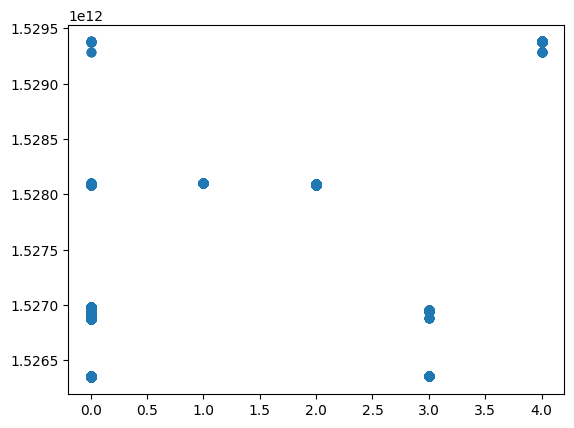

<IPython.core.display.Javascript object>

In [8]:
times = pyg_lg.x[:, 49]
attacks = pyg_lg.Attack

plt.scatter(attacks, times)
plt.show()

In [9]:
df = pd.read_csv('../../interm/archive/BoT-IoT_reduced.csv')
df

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Attack
0,1.528104e+12,1.528104e+12,192.168.100.7,365,192.168.100.3,565,17,0.0,238142,5177,...,0,1.0,30.0,22.0,4.0,0.0,0.0,0.0,0.0,Benign
1,1.528104e+12,1.528104e+12,192.168.100.46,3456,192.168.100.5,80,17,0.0,9015892,9630,...,0,1.0,28.0,12.0,1.0,1.0,30.0,12.0,2.0,Benign
2,1.528104e+12,1.528104e+12,192.168.100.55,8080,192.168.100.3,80,6,7.0,9551084,9630,...,0,1.0,30.0,12.0,1.0,5.0,25.0,12.0,1.0,Benign
3,1.528104e+12,1.528104e+12,192.168.100.46,80,192.168.100.5,80,17,0.0,9106323,9630,...,0,1.0,28.0,12.0,2.0,0.0,0.0,0.0,0.0,Benign
4,1.528104e+12,1.528104e+12,192.168.100.6,80,192.168.100.3,80,6,7.0,916500,3250,...,0,12.0,54.0,36.0,4.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74391,1.529381e+12,1.529381e+12,192.168.100.3,43297,192.168.100.150,4433,6,0.0,60,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft
74392,1.529381e+12,1.529381e+12,192.168.100.3,55111,192.168.100.149,4433,6,0.0,60,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft
74393,1.529381e+12,1.529381e+12,192.168.100.3,43299,192.168.100.150,4433,6,0.0,60,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft
74394,1.529381e+12,1.529381e+12,192.168.100.3,55113,192.168.100.149,4433,6,0.0,60,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft


<IPython.core.display.Javascript object>

In [10]:
df = df.sort_values(by='FLOW_START_MILLISECONDS')

<IPython.core.display.Javascript object>

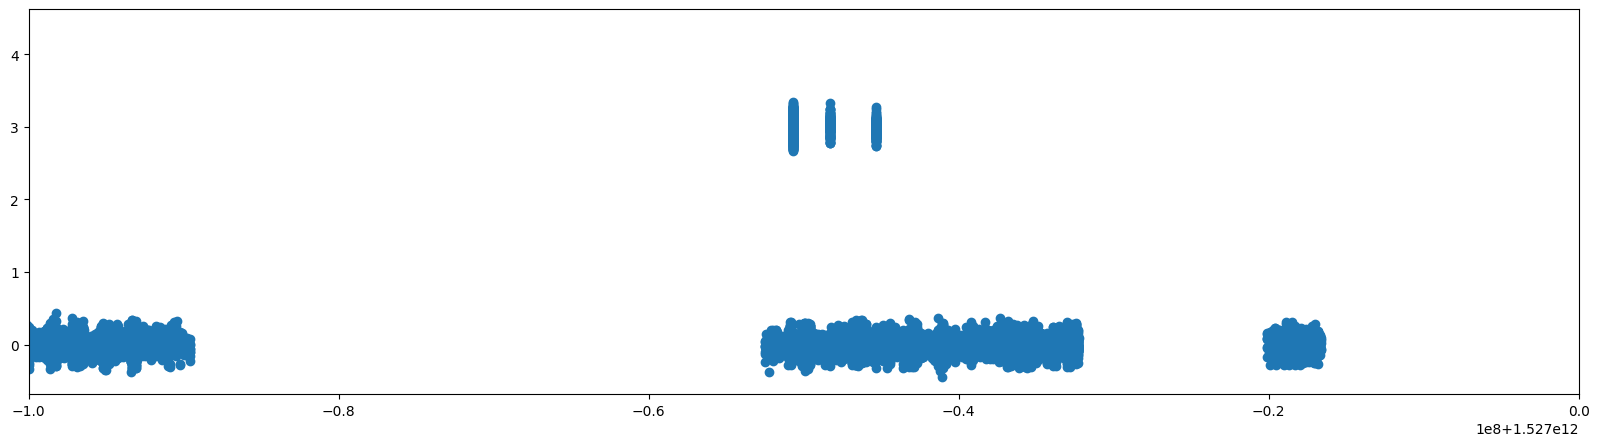

<IPython.core.display.Javascript object>

In [11]:
f, a = plt.subplots(figsize=(20, 5))

noise_y = [np.random.normal(0, scale=0.1) + a for a in le['Attack'].transform(df['Attack'])]

plt.scatter(
    df['FLOW_START_MILLISECONDS'], 
    noise_y
) 

plt.xlim((1.5269e12, 1.5270e12))
plt.show()

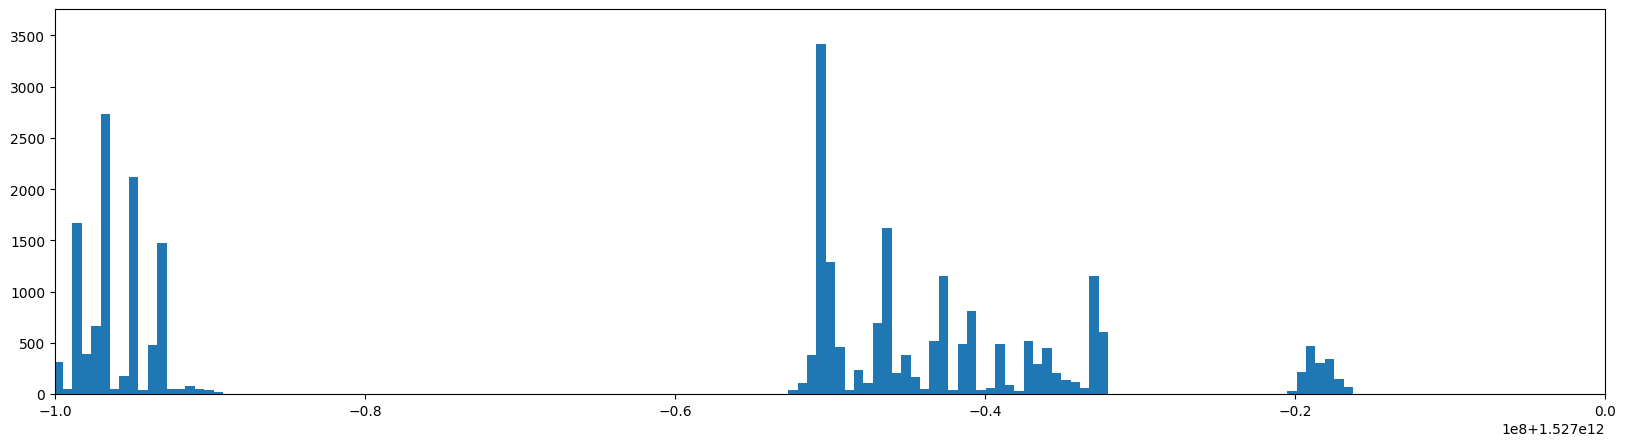

<IPython.core.display.Javascript object>

In [12]:
f, a = plt.subplots(figsize=(20, 5))

plt.hist(
    df['FLOW_START_MILLISECONDS'], 
    bins=5000
) 

plt.xlim((1.5269e12, 1.5270e12))
plt.show()

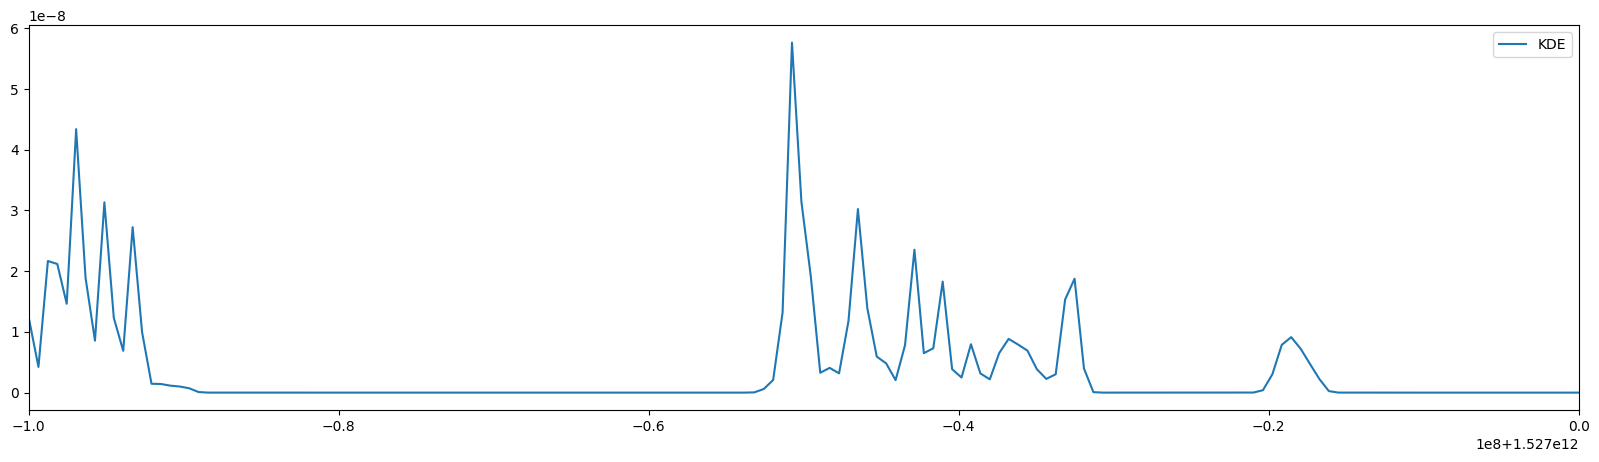

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

x = df['FLOW_START_MILLISECONDS'].values

kde = gaussian_kde(x, bw_method=0.0005) 

x_grid = np.linspace(x.min(), x.max(), 5000)
y_vals = kde.evaluate(x_grid)

plt.figure(figsize=(20, 5))
plt.xlim((1.5269e12, 1.5270e12))
plt.plot(x_grid, y_vals, label="KDE")
plt.legend()
plt.show()


### NIDS-GNNExplainer
- motif coherence reward $= - \lambda_{mc} \cdot \sum_{g \in \text{motifs}} || m_g ||_2$
- temporal smoothness penalty =  $\lambda_{ts} \cdot \text{exp}(\frac{-(t_i - t_j)^2}{2\sigma^2}) ||m_i - m_j||^2$
- threshhold sparsity penalty = $1/N \sum \mathcal{I}(n > k) $

In [30]:

import torch
import torch.nn.functional as F
from torch_geometric.explain import GNNExplainer
from sklearn.neighbors import KernelDensity


class CustomGNNExplainer(GNNExplainer):
    
    params = {
        'ts_coef': 0,
        'motif_coef': 0,
        'sparsity_coef': 0,
        'sparsity_threshold': 0,
        'kde_bw': 0.0005
    }
    
    epoch_metrics = {
        'temporal smoothness reward': [],
        'motif coherance reward': [],
        'base loss': [],
    }
    
    def __init__(
        self, 
        node_times, 
        motif_groups, 
        **kwargs
    ):
        super().__init__(**kwargs)
        self.params.update(kwargs)
        self.node_times = node_times 
        self.motif_groups = motif_groups

    # def temporal_smoothness(self, node_mask):
    #     order = torch.argsort(self.node_times)
    #     times = self.node_times[order]
    #     time_diffs = (times[1:] - times[:-1])
    #     ordered_node_importances = node_mask[order].mean(axis=1)
    #     w_ij = torch.exp(- (time_diffs**2) / (2 * time_diffs.std()**2))
    #     spread = (w_ij * (( ordered_node_importances [1:] 
    #                       - ordered_node_importances[:-1] ) ** 2)).sum()
        
    #     return self.params['ts_coef'] * spread
    
    # def temporal_smoothness(self, node_mask, threshold=0.5):
    #     order = torch.argsort(self.node_times)
    #     ordered_times = self.node_times[order]
        
    #     ordered_node_significance = torch.Tensor([
    #         max(n) for n in node_mask 
    #     ])[order]
        
    #     chosen_times = ordered_times[ordered_node_significance > threshold]
        
    #     if len(chosen_times) == 0:
    #         return 0

    #     X = chosen_times[:, np.newaxis]
    #     kde = KernelDensity(kernel='gaussian', bandwidth=self.params['kde_bw']
    #                         ).fit(X)

    #     log_densities = kde.score_samples(X)
    #     densities = np.exp(log_densities)  
        
    #     # scale by significant nodes counts
    #     # to prevent sparsity inflation
        
    #     return densities.mean() / len(chosen_times)   
        
        
    def temporal_smoothness(self, node_mask, threshold=0.5):
        order = torch.argsort(self.node_times)
        ordered_times = self.node_times[order]

        ordered_node_significance = torch.tensor([
            max(n) for n in node_mask
        ])[order]

        chosen_times = ordered_times[ordered_node_significance > threshold]

        if len(chosen_times) <= 1:
            return 0.0

        # Normalize variance relative to range
        var = np.var(chosen_times.cpu().numpy())
        max_var = (chosen_times.max() - chosen_times.min()).item()**2 / 4  # variance of uniform
        score = 1 - var / max_var
        return float(np.clip(score, 0, 1))
    
    def motif_coherance(self, node_mask):
        coherance = sum([
            self.params['motif_coef'] * torch.norm(node_mask[g], p=2)
            for g in self.motif_groups
        ])
        return coherance / len(self.motif_groups)

    def additional_loss_terms(self, node_mask):
        reg = 0

        ts = self.temporal_smoothness(node_mask)
        self.epoch_metrics['temporal smoothness reward'].append(ts)
        print(f'temporal smoothness (reward): {ts}')
        reg -= ts

        if len(self.motif_groups) > 0:
            mc = self.motif_coherance(node_mask)
            self.epoch_metrics['motif coherance reward'].append(mc)
            print(f'motif coherance (reward): {mc}')
            reg -= mc
        
        return reg

    def plot_descent(self):
        with plt.style.context('science'): 
            for l in self.epoch_metrics.values():
                plt.plot(l)
            plt.legend(self.epoch_metrics.keys())
            plt.show()

    # def _loss(self, log_logits, pred_label, node_mask, feat_mask):
    def _loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        base_loss = super()._loss(y_hat, y)
        reg_loss = self.additional_loss_terms(self.node_mask)
        print(f'base_loss: {base_loss}')
        print(f'total loss: {base_loss + reg_loss}\n')
        self.epoch_metrics['base loss'].append(base_loss)
        return base_loss + reg_loss
    


<IPython.core.display.Javascript object>

### Eval

In [ ]:
import copy

metrics = {}
epoch_metrics = {}


## !!! ONLY USE SPECIFIC MOTIFS FOR SPECIFIC CLASSES

for attack, subG in yield_class_graphs(pyg_lg):
    if attack == 'Benign': 
        continue
    
    print(attack)

    is_star, is_fan = subG.x[:, 51], subG.x[:, 52]
    end_times, start_times = subG.x[:, 50], subG.x[:, 49]
    scanning_star_nodes = is_star.nonzero(as_tuple=True)[0]
    fan_nodes = is_fan.nonzero(as_tuple=True)[0]
    src, dst = subG.edge_index[0], subG.edge_index[1]

    star_motifs = []
    if attack == 'Dos':
        for hub in scanning_star_nodes.tolist():
            lg_nodes = (src == hub).nonzero(as_tuple=True)[0].tolist()
            if lg_nodes: 
                star_motifs.append(lg_nodes)

    fan_motifs = []
    if attack == 'DDos':    
        for sink in fan_nodes.tolist():
            lg_nodes = (dst == sink).nonzero(as_tuple=True)[0].tolist()
            if lg_nodes:
                fan_motifs.append(lg_nodes)
    
    explainer = Explainer(
        model=model,
        algorithm=CustomGNNExplainer(
            epochs=100, 
            node_times = start_times,
            motif_groups = (star_motifs + fan_motifs),
            tv_coef = 0.05,
            motif_coef = 0.05,
        ),
        explanation_type='phenomenon',
        node_mask_type='attributes',
        edge_mask_type=None,
        model_config=ModelConfig(
            mode='multiclass_classification',
            task_level='node',
            return_type='raw',
        ),
    )  
    
    print(subG.x.shape)
    print(subG.Attack.shape)

    x = subG.x[:, :49]
    explanation = explainer(
        x=x,
        edge_index=subG.edge_index.to(device),
        target=subG.Attack,
    )
    
    metrics[attack] = explanation 
    subG_cp = copy.deepcopy(subG)
    subG_cp.x = subG_cp.x[:, :49]
    
    # softmask metrics
    fp, fn, c = evaluate_softmask(model, subG_cp, explanation.node_mask)
    metrics[f'{attack} softmask metrics'] = fp, fn, c
    print(f'\tfp: {fp:.3f}')
    print(f'\tfn: {fn:.3f}')
    print(f'\tc: {c:.3f}')
    
    # sparsity curve
    metrics[f'{attack} sparsity curve'] = evaluate_sparsity_threshholds(
        model, subG_cp, explanation.node_mask)
    
    del subG_cp
    epoch_metrics[attack] = explainer.algorithm.epoch_metrics
    

DDoS
torch.Size([10168, 53])
torch.Size([10168])


temporal smoothness (reward): 0.0
base_loss: 0.5475847721099854
total loss: 0.5475847721099854

temporal smoothness (reward): 0.0
base_loss: 1.1110152006149292
total loss: 1.1110152006149292

temporal smoothness (reward): 0.0
base_loss: 1.1044119596481323
total loss: 1.1044119596481323

temporal smoothness (reward): 0.0
base_loss: 1.0976874828338623
total loss: 1.0976874828338623

temporal smoothness (reward): 0.0
base_loss: 1.0909274816513062
total loss: 1.0909274816513062

temporal smoothness (reward): 0.0
base_loss: 1.0841851234436035
total loss: 1.0841851234436035

temporal smoothness (reward): 0.0
base_loss: 1.0774582624435425
total loss: 1.0774582624435425

temporal smoothness (reward): 0.0
base_loss: 1.0707563161849976
total loss: 1.0707563161849976

temporal smoothness (reward): 0.0
base_loss: 1.0640952587127686
total loss: 1.0640952587127686

temporal smoothness (reward): 0.0
base_loss: 1.0574735403060913
total loss: 1.0574735403060913

temporal smoothness (reward): 0.0
base_l

100%|██████████| 9/9 [00:00<00:00, 12.74it/s]


DoS
torch.Size([10144, 53])
torch.Size([10144])
temporal smoothness (reward): 0.0
base_loss: 0.33604511618614197
total loss: 0.33604511618614197

temporal smoothness (reward): 0.0
base_loss: 0.90020751953125
total loss: 0.90020751953125

temporal smoothness (reward): 0.0
base_loss: 0.8942633867263794
total loss: 0.8942633867263794

temporal smoothness (reward): 0.0
base_loss: 0.8882095217704773
total loss: 0.8882095217704773

temporal smoothness (reward): 0.0
base_loss: 0.8821413516998291
total loss: 0.8821413516998291

temporal smoothness (reward): 0.0
base_loss: 0.8760889768600464
total loss: 0.8760889768600464

temporal smoothness (reward): 0.0
base_loss: 0.870066225528717
total loss: 0.870066225528717

temporal smoothness (reward): 0.0
base_loss: 0.8640801310539246
total loss: 0.8640801310539246

temporal smoothness (reward): 0.0
base_loss: 0.8581395149230957
total loss: 0.8581395149230957

temporal smoothness (reward): 0.0
base_loss: 0.8522502183914185
total loss: 0.85225021839141

100%|██████████| 9/9 [00:00<00:00, 13.77it/s]


Reconnaissance
torch.Size([10138, 53])
torch.Size([10138])
temporal smoothness (reward): 0.0
base_loss: 0.4180094599723816
total loss: 0.4180094599723816

temporal smoothness (reward): 0.0
base_loss: 0.9820777177810669
total loss: 0.9820777177810669

temporal smoothness (reward): 0.0
base_loss: 0.9761021137237549
total loss: 0.9761021137237549

temporal smoothness (reward): 0.0
base_loss: 0.9700018167495728
total loss: 0.9700018167495728

temporal smoothness (reward): 0.0
base_loss: 0.9638693332672119
total loss: 0.9638693332672119

temporal smoothness (reward): 0.0
base_loss: 0.9577437043190002
total loss: 0.9577437043190002

temporal smoothness (reward): 0.0
base_loss: 0.9516334533691406
total loss: 0.9516334533691406

temporal smoothness (reward): 0.0
base_loss: 0.9455479383468628
total loss: 0.9455479383468628

temporal smoothness (reward): 0.0
base_loss: 0.9394945502281189
total loss: 0.9394945502281189

temporal smoothness (reward): 0.0
base_loss: 0.9334802627563477
total loss: 0

fid-


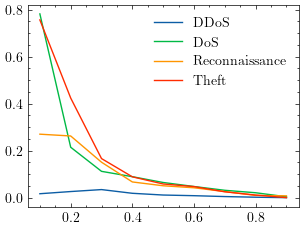

fid+


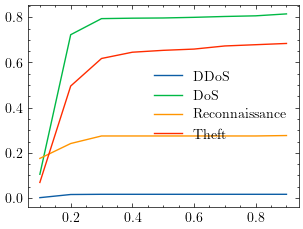

c


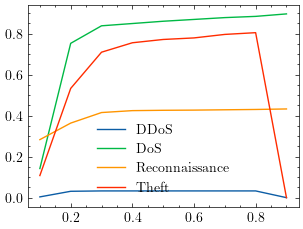

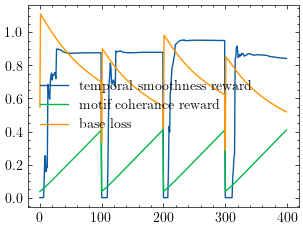

<IPython.core.display.Javascript object>

In [25]:

plt.show()

# plot sparsity curves
with plt.style.context('science'): 
    for metric in ('fid-', 'fid+', 'c'):
        print(metric)
        for attack in le['Attack'].classes_:
            if attack == 'Benign': 
                continue

            m = metrics[f'{attack} sparsity curve']
            plt.plot(m['s'], m[metric])
        
        plt.legend(le['Attack'].classes_[1:])
        plt.show()  
        
        

with plt.style.context('science'): 
    for m, l in explainer.algorithm.epoch_metrics.items():
        if type(l[0]) is torch.Tensor:
            plt.plot([ll.detach().numpy() for ll in l])
        else:
            plt.plot(l)

    plt.legend(explainer.algorithm.epoch_metrics.keys())
    plt.show()

fid-


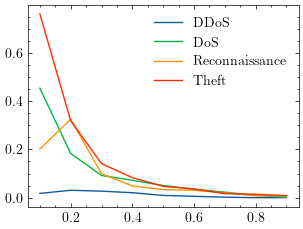

fid+


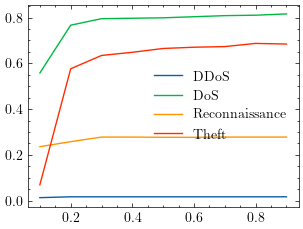

c


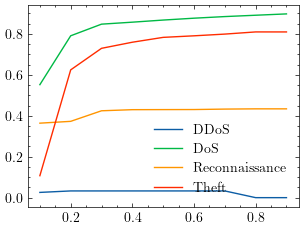

<IPython.core.display.Javascript object>

In [ ]:
# plot sparsity curves
with plt.style.context('science'): 
    for metric in ('fid-', 'fid+', 'c'):
        print(metric)
        for attack in le['Attack'].classes_:
            if attack == 'Benign': 
                continue

            m = metrics[f'{attack} sparsity curve']
            plt.plot(m['s'], m[metric])
        
        plt.legend(le['Attack'].classes_[1:])
        plt.show()   

In [ ]:
metrics['epoch metrics'] = explainer.algorithm.epoch_metrics
with open('../../interm/nidse_metrics', 'wb') as f:
    pickle.dump(metrics, f)

<IPython.core.display.Javascript object>